In [1]:
#Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp

In [2]:
#Como trabajamos con Visual, esta línea imprime los gráficos
%matplotlib inline

In [3]:
#Leyendo la data
df_salary = pd.read_csv('../data/Salary_data.csv')
df_salary.shape 

(62642, 29)

In [4]:
#Generando un reporte de la data sin procesar
profile = pp.ProfileReport(df_salary, title='Pandas Profiling Report', minimal=True)
profile.to_file('../data/reports/Raw_data.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 249.93it/s]


In [5]:
df_salary.columns #Observamos los nombres de sus columnas

Index(['timestamp', 'company', 'level', 'title', 'totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus', 'gender', 'otherdetails', 'cityid', 'dmaid',
       'rowNumber', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree',
       'Highschool', 'Some_College', 'Race_Asian', 'Race_White',
       'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic', 'Race', 'Education'],
      dtype='object')

In [6]:
#Seleccionamos las columnas con las que trabajaremos
selected_columns = ['company','totalyearlycompensation','basesalary','gender','Race','Education']

In [7]:
#Creamos una nueva tabla para trabajar con ella
df = df_salary[selected_columns].copy()
df.shape

(62642, 6)

In [8]:
df.isnull().sum()

company                        5
totalyearlycompensation        0
basesalary                     0
gender                     19540
Race                       40215
Education                  32272
dtype: int64

In [9]:
#Como obersvamos que los valores nulos se encuentran dentro de las columnas de tipo texto, les hacemos un filtro básico
df_filtrado = df.fillna({'company':'No especificado','tag':'No especificado','gender':'No especificado','Race':'No especificado','Education':'No especificado',})
df = df_filtrado
df.isnull().sum()

company                    0
totalyearlycompensation    0
basesalary                 0
gender                     0
Race                       0
Education                  0
dtype: int64

Detalle en la columna género

In [10]:
df.gender.unique() 

array(['No especificado', 'Male', 'Female', 'Other',
       'Title: Senior Software Engineer'], dtype=object)

In [11]:
#Obervamos algo inusual dentro del género: "Título: Ingeniero de software senior", ¡¿Cómo?!
#Establecemos que cuando haya algún dato que no sea "Male o Female" se guarden como "Other"
df['gender'] = np.where(df['gender'].isin(['Male','Female','No especificado']), df['gender'], 'Other') 

df.gender.unique() #Verificamos

array(['No especificado', 'Male', 'Female', 'Other'], dtype=object)

Detalle con los nombres de las compañías

In [12]:
nom_company = pd.DataFrame(df.company.unique()).set_index(0)
nom_company.shape

(1632, 0)

In [13]:
nom_company.head(20).T #Observaremos que algunos ingresaron la misma compañia con diferente tipeado
#Por lo que trataremos de que más adelante al agruparlos no los cuenten por separado
#Se oberva por un lado 'Amazon' y por otro 'amazon'
#Psdta: en estos casos uso la transversa para que no me ocupe muchas líneas hacia abajo

,Oracle,eBay,Amazon,Apple,Microsoft,Salesforce,Facebook,Uber,Oath,Google,Netflix,Pinterest,Linkedin,Adobe,LinkedIn,amazon,Symantec,Intel Corporation,Intel,Lyft


In [14]:
nom_company.loc[['Google','IBM','ibm','GOogle','MSFT']].T  #Ejecutando este código obervaremos un ejemplo del bloque anterior

,Google,IBM,ibm,GOogle,MSFT


In [15]:
nom_company_mayus = df['company'].str.upper() #Convertimos todos los valores a mayúsculas
nom_company_mayus.unique().shape #Comprobamos

(1102,)

In [16]:
df['company'] = np.asarray(df['company'].str.upper()) #Convertimos todos los valores en la data original a mayúsculas
df['company'].unique().shape #Comprobamos que la cantidad coincida con la cantidad sacada en la prueba del bloque anterior

(1102,)

In [17]:
#Gracias al detalle que observamos 3 bloques arriba, 'MSFT', lo cambiamos por 'Microsoft'
df['company'] = df['company'].replace(to_replace='MSFT', value='MICROSOFT')

In [18]:
#Hacemos un filtro para que las empresas que contengan las variables ingresadas se reemplazen por estas y
#así evitar que se realicen conteos por separado al momento de realizar un análisis con los agrupamientos de columnas
lista = ['INTEL','AMAZON','GOOGLE','APPLE','NETFLIX','MICROSOFT']
for i in lista:
    df['company'] = np.where(df['company'].str.contains(i), i, df['company'])

In [19]:
df.company.nunique()

1094

In [20]:
#SI COMENTAMOS ESTAS 2 LINEAS COMPRORAREMOS QUE PRECISAMENTE SE REALIZARON LOS CAMBIOS
#Psdt: Al ejecutar saldrá error, ya que no se encontrarán estos valores
#ncom = pd.DataFrame(df.company.unique()).set_index(0)
#ncom.loc[['Google','IBM','ibm','GOogle','MSFT']].T

In [21]:
df.describe().round(2)

,totalyearlycompensation,basesalary
count,62642.00,62642.00
mean,216300.37,136687.28
std,138033.75,61369.28
min,10000.00,0.00
25%,135000.00,108000.00
50%,188000.00,140000.00
75%,264000.00,170000.00
max,4980000.00,1659870.00


Observación en la columna 'basesalary'

In [22]:
#Observamos que hay demasiados puestos con oferta de trabajo sin salario base
df[df['basesalary']==0].size

13824

In [23]:
#Reemplazamos los valores ingresados como 0 por el promedio de la columna
df['basesalary'].replace(0, np.mean(df['basesalary']), inplace=True)

In [24]:
df[df['basesalary'] == 0].size #Corroboramos

0

Outliers

<AxesSubplot:>

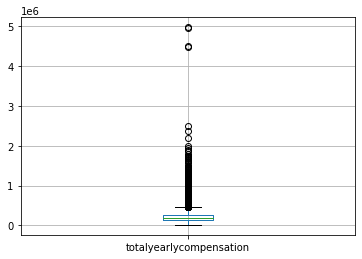

In [25]:
#Se observa un sesgo en cuanto a la recolección de datos, contamos con demasiados valores atípicos
df.boxplot('totalyearlycompensation')

In [26]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df <(Q1 -1.5* IQR))|(df >(Q3 +1.5* IQR))).any(axis=1)]

C:\Users\Administrador\AppData\Local\Temp\ipykernel_10768\3547905242.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[~((df <(Q1 -1.5* IQR))|(df >(Q3 +1.5* IQR))).any(axis=1)]


<AxesSubplot:>

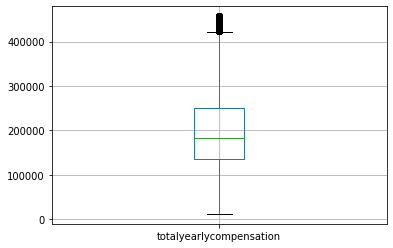

In [27]:
df.boxplot('totalyearlycompensation') #Comprobando la actualización con la eliminación de outliers

In [28]:
#Generando un reporte de la data procesada
profile_l = pp.ProfileReport(df_salary, title='Pandas Profiling Report', minimal=True)
profile_l.to_file('../data/reports/Clean_data.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 199.83it/s]


In [29]:
df.to_csv('../data/Data_limpia.csv',index = False) #Guardando la data procesada

# 